# Imports

In [57]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_recall_curve, confusion_matrix,roc_curve, roc_auc_score
from sklearn.model_selection import StratifiedKFold


In [58]:

validation_ids = pd.read_csv('/Users/paigegiese/SYG/wids-2025-mupd/data/TRAIN/validation_ids.csv')['participant_id'].tolist()
d1 = pd.read_csv('/Users/paigegiese/SYG/wids-2025-mupd/data/TRAIN/TRAIN_CATEGORICAL_METADATA.csv')
d1 = d1.loc[~d1['participant_id'].isin(validation_ids)].reset_index(drop=True)
d2 = pd.read_csv('/Users/paigegiese/SYG/wids-2025-mupd/data/TRAIN/TRAIN_QUANTITATIVE_METADATA.csv')
d2 = d2.loc[~d2['participant_id'].isin(validation_ids)].reset_index(drop=True)
labels = pd.read_csv('/Users/paigegiese/SYG/wids-2025-mupd/data/TRAIN/TRAINING_SOLUTIONS.csv')
labels = labels.loc[~labels['participant_id'].isin(validation_ids)].reset_index(drop=True)
df = d1.merge(d2, on='participant_id').merge(labels, on='participant_id')


# Features from EDA

In [59]:
# limiting to only a few of the most salient features from EDA
adhd_cols = ['participant_id', 
'Basic_Demos_Enroll_Year',
'Basic_Demos_Study_Site',
'MRI_Track_Scan_Location',
'APQ_P_APQ_P_CP',
'APQ_P_APQ_P_ID', 
'APQ_P_APQ_P_INV',
'APQ_P_APQ_P_OPD',
'APQ_P_APQ_P_PM', 
'APQ_P_APQ_P_PP',
'SDQ_SDQ_Conduct_Problems', 
'SDQ_SDQ_Difficulties_Total',
'SDQ_SDQ_Emotional_Problems',
'SDQ_SDQ_Externalizing',
'SDQ_SDQ_Generating_Impact', 
'SDQ_SDQ_Hyperactivity',
'SDQ_SDQ_Internalizing',
'SDQ_SDQ_Peer_Problems', 
'SDQ_SDQ_Prosocial',
'MRI_Track_Age_at_Scan',
'ADHD_Outcome',
'Sex_F'
 ]

# female_cols = ['ColorVision_CV_Score',
# 'SDQ_SDQ_Emotional_Problems',
# 'SDQ_SDQ_Externalizing',
# 'SDQ_SDQ_Hyperactivity',
# 'SDQ_SDQ_Internalizing',
# 'SDQ_SDQ_Prosocial',
# 'Sex_F',
# 'participant_id']
female_cols = adhd_cols.copy()
female_cols.extend(['ColorVision_CV_Score','EHQ_EHQ_Total',
                    # 'Barratt_Barratt_P1_Edu', 
                    # 'Barratt_Barratt_P2_Edu'
                    ])


sex_df = df.loc[:,female_cols]
adhd_df = df.loc[:,adhd_cols]

In [60]:
# Barratt_Barratt_P1_Edu 21, 18, 15, 12
# Barratt_Barratt_P2_Edu 21, 18, 0, 15, 12
#sex_df['Barratt_Barratt_P2_Edu'].value_counts(normalize=True).cumsum()[:5].index


# ADHD Model

## Preprocessing

In [61]:
# ugly, but can speed me up later.
def prep(df):
    df['Basic_Demos_Enroll_Year'] = df['Basic_Demos_Enroll_Year'].astype('str')
    df['Basic_Demos_Study_Site'] = df['Basic_Demos_Study_Site'].astype('str')
    df['MRI_Track_Scan_Location'] = df['MRI_Track_Scan_Location'].astype('str')
    df['TF_MRI_Track_Age_at_Scan'] = pd.cut(df['MRI_Track_Age_at_Scan'], 4, labels=False).fillna('Missing')
    try:
        df['Barratt_Barratt_P1_Edu'] = df['Barratt_Barratt_P1_Edu'].astype('str')
        df['Barratt_Barratt_P2_Edu'] = df['Barratt_Barratt_P2_Edu'].astype('str')
        df.loc[~df['Barratt_Barratt_P1_Edu'].isin(['21', '18', '15', '12']),'Barratt_Barratt_P1_Edu'] = 'Other' # grouping for noise
        df.loc[~df['Barratt_Barratt_P2_Edu'].isin(['21', '18', '0', '15','12']),'Barratt_Barratt_P2_Edu'] = 'Other' # grouping for noise
        
    except: 
        pass
    df.loc[df['TF_MRI_Track_Age_at_Scan']==0,'TF_MRI_Track_Age_at_Scan'] = 'Missing' # lumping in with Missing
    df.loc[df['MRI_Track_Scan_Location']==0,'MRI_Track_Scan_Location'] = 'Missing' # to match the feature eng on MRI_Track_Age_at_Scan
    try:
        final_df = pd.get_dummies(df, columns=['Basic_Demos_Enroll_Year', 'MRI_Track_Scan_Location','TF_MRI_Track_Age_at_Scan','Basic_Demos_Study_Site','Barratt_Barratt_P1_Edu','Barratt_Barratt_P2_Edu']).reset_index(drop=True)
        final_df['EHQ_EHQ_Total'] = final_df['EHQ_EHQ_Total']/10
        final_df.drop(['Basic_Demos_Enroll_Year_2017', 'MRI_Track_Scan_Location_1','TF_MRI_Track_Age_at_Scan_3.0','Basic_Demos_Study_Site_4','Barratt_Barratt_P1_Edu_Other','Barratt_Barratt_P2_Edu_Other','MRI_Track_Age_at_Scan'], axis=1, inplace=True)
    except:
        final_df = pd.get_dummies(df, columns=['Basic_Demos_Enroll_Year', 'MRI_Track_Scan_Location','TF_MRI_Track_Age_at_Scan','Basic_Demos_Study_Site']).reset_index(drop=True)
        final_df.drop(['Basic_Demos_Enroll_Year_2017', 'MRI_Track_Scan_Location_1','TF_MRI_Track_Age_at_Scan_3.0','Basic_Demos_Study_Site_4','MRI_Track_Age_at_Scan'], axis=1, inplace=True)
        
    #print(adhd_df.columns)
    #adhd_df.set_index('participant_id', inplace=True)
    

    return final_df


## Model run

In [146]:
adhd_df = prep(adhd_df)

In [147]:
adhd_df

,participant_id,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Emotional_Problems,...,MRI_Track_Scan_Location_0,MRI_Track_Scan_Location_2,MRI_Track_Scan_Location_3,MRI_Track_Scan_Location_4,TF_MRI_Track_Age_at_Scan_1.0,TF_MRI_Track_Age_at_Scan_2.0,TF_MRI_Track_Age_at_Scan_Missing,Basic_Demos_Study_Site_1,Basic_Demos_Study_Site_2,Basic_Demos_Study_Site_3
0,UmrK0vMLopoR,3,10,47,13,11,28,0,6,1,...,False,False,False,False,False,False,True,True,False,False
1,CPaeQkhcjg7d,3,13,34,18,23,30,0,18,6,...,False,False,True,False,False,False,True,False,False,True
2,Nb4EetVPm3gs,4,10,35,16,10,29,1,14,2,...,False,False,False,False,True,False,False,True,False,False
3,p4vPhVu91o4b,5,12,39,19,16,28,6,24,4,...,False,False,True,False,False,False,True,False,False,True
4,M09PXs7arQ5E,5,15,40,20,24,28,1,18,4,...,False,False,True,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1027,8ZqEcqENo02n,3,10,45,13,14,28,0,0,0,...,False,False,False,False,False,True,False,True,False,False
1028,8RqLpySUwmWx,3,6,49,21,14,30,0,0,0,...,False,True,False,False,True,False,False,True,False,False
1029,Zusa1n9tQ3Yb,5,20,45,21,20,29,1,9,2,...,False,False,True,False,False,False,True,False,False,True
1030,Atx7oub96GXS,5,14,39,20,15,21,1,9,2,...,False,True,False,False,True,False,False,True,False,False


In [148]:
X = adhd_df.drop(['ADHD_Outcome', 'Sex_F'], axis=1)
y_adhd_outcome = adhd_df['ADHD_Outcome'].values
X.set_index('participant_id', inplace=True)

In [149]:
X.isna().sum()

APQ_P_APQ_P_CP                      0
APQ_P_APQ_P_ID                      0
APQ_P_APQ_P_INV                     0
APQ_P_APQ_P_OPD                     0
APQ_P_APQ_P_PM                      0
APQ_P_APQ_P_PP                      0
SDQ_SDQ_Conduct_Problems            0
SDQ_SDQ_Difficulties_Total          0
SDQ_SDQ_Emotional_Problems          0
SDQ_SDQ_Externalizing               0
SDQ_SDQ_Generating_Impact           0
SDQ_SDQ_Hyperactivity               0
SDQ_SDQ_Internalizing               0
SDQ_SDQ_Peer_Problems               0
SDQ_SDQ_Prosocial                   0
Basic_Demos_Enroll_Year_2015        0
Basic_Demos_Enroll_Year_2016        0
Basic_Demos_Enroll_Year_2018        0
Basic_Demos_Enroll_Year_2019        0
Basic_Demos_Enroll_Year_2020        0
MRI_Track_Scan_Location_0           0
MRI_Track_Scan_Location_2           0
MRI_Track_Scan_Location_3           0
MRI_Track_Scan_Location_4           0
TF_MRI_Track_Age_at_Scan_1.0        0
TF_MRI_Track_Age_at_Scan_2.0        0
TF_MRI_Track

In [150]:
# Split once for multiple y variables
X_train, X_test, y1_train, y1_test = train_test_split(
    X, y_adhd_outcome, test_size=0.15, random_state=42
)

In [151]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Create an ensemble model using VotingClassifier (stacking)
ensemble_model= VotingClassifier(
    estimators=[('rf', rf_classifier), ('gb', gb_classifier)],
    voting='soft'  # 'hard' for majority class voting
)

ensemble_model.fit(X_train, y1_train) 
y_pred_proba= ensemble_model.predict_proba(X_test)
y_pred= ensemble_model.predict(X_test)
final_feature_names = ensemble_model.feature_names_in_
# Default accuracies
print(f"Accuracy for adhd (classification): {accuracy_score(y1_test, y_pred):.4f}")
print(f"F1 for adhd (classification): {f1_score(y1_test, y_pred):.4f}")

Accuracy for adhd (classification): 0.8000
F1 for adhd (classification): 0.8597


In [152]:
feature_importances = {}
for model in ensemble_model.named_estimators_:
    clfr= ensemble_model.named_estimators_[model]
    importances = clfr.feature_importances_
    feature_importances[(model)] = importances    

In [153]:
feature_names = X_train.columns
avg_importance = np.mean(list(feature_importances.values()), axis=0)
importance_dict = dict(zip(feature_names, avg_importance))
sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)
for feature, importance in sorted_importance:
    print(f"{feature}: {importance:.4f}")

SDQ_SDQ_Hyperactivity: 0.3379
SDQ_SDQ_Difficulties_Total: 0.0737
SDQ_SDQ_Generating_Impact: 0.0674
SDQ_SDQ_Externalizing: 0.0599
APQ_P_APQ_P_INV: 0.0475
APQ_P_APQ_P_PM: 0.0447
APQ_P_APQ_P_OPD: 0.0430
APQ_P_APQ_P_PP: 0.0369
SDQ_SDQ_Internalizing: 0.0309
APQ_P_APQ_P_CP: 0.0304
APQ_P_APQ_P_ID: 0.0295
SDQ_SDQ_Prosocial: 0.0283
SDQ_SDQ_Emotional_Problems: 0.0266
SDQ_SDQ_Conduct_Problems: 0.0219
SDQ_SDQ_Peer_Problems: 0.0201
Basic_Demos_Enroll_Year_2016: 0.0198
Basic_Demos_Enroll_Year_2018: 0.0139
MRI_Track_Scan_Location_3: 0.0107
TF_MRI_Track_Age_at_Scan_1.0: 0.0106
Basic_Demos_Enroll_Year_2019: 0.0089
TF_MRI_Track_Age_at_Scan_2.0: 0.0066
TF_MRI_Track_Age_at_Scan_Missing: 0.0063
Basic_Demos_Study_Site_1: 0.0062
Basic_Demos_Study_Site_3: 0.0061
Basic_Demos_Enroll_Year_2015: 0.0050
MRI_Track_Scan_Location_2: 0.0049
MRI_Track_Scan_Location_4: 0.0018
Basic_Demos_Study_Site_2: 0.0005
MRI_Track_Scan_Location_0: 0.0001
Basic_Demos_Enroll_Year_2020: 0.0000


Text(0.5, 1.0, 'Actual vs Predicted Distributions')

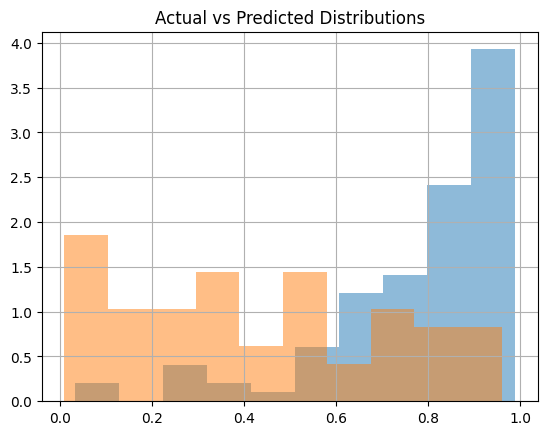

In [154]:
test_df_adhd = pd.DataFrame(list(zip(y1_test,(y_pred_proba[:,1]))), columns=['actual','predicted'])

# Plot the distros and look at spread
test_df_adhd.loc[test_df_adhd['actual']==1]['predicted'].hist(alpha=.5, label='ADHD', density=True)
test_df_adhd.loc[test_df_adhd['actual']==0]['predicted'].hist(alpha=.5, label='No ADHD', density=True)
plt.title('Actual vs Predicted Distributions')


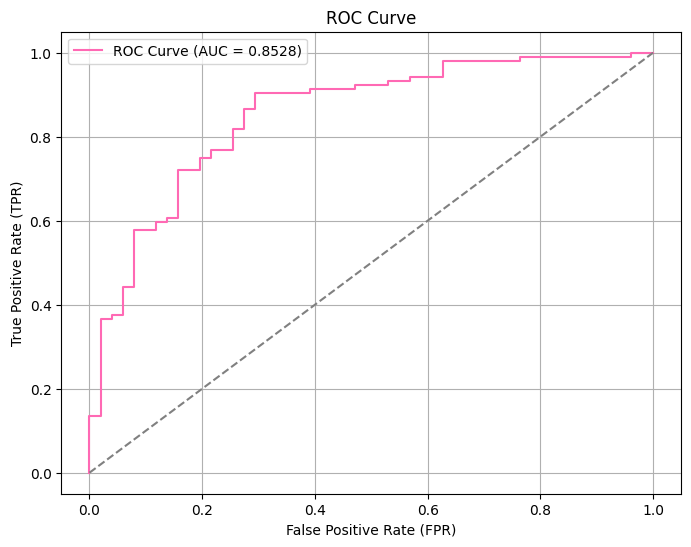

In [155]:

precision_vals, recall_vals, thresholds = precision_recall_curve(y1_test, y_pred_proba[:,1])
# Compute ROC curve and AUC score

fpr, tpr, roc_thresholds = roc_curve(y1_test, y_pred_proba[:, 1])  # Assuming y_pred contains probabilities for class 1
auc_score = roc_auc_score(y1_test, y_pred_proba[:, 1])

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='hotpink', label=f'ROC Curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--') 
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()



In [156]:
# Compute optimal threshold
j_scores = tpr - fpr 
optimal_idx = j_scores.argmax()  
optimal_threshold = roc_thresholds[optimal_idx]

#Redoing with optimal threshold.
y_pred_thresh = (y_pred_proba[:, 1] >= optimal_threshold).astype(int)  # Taking column 1 (positive class probability)
print('Original accuracies:')
print(f"Accuracy for adhd (classification): {accuracy_score(y1_test, y_pred):.4f}")
print(f"F1 for adhd (classification): {f1_score(y1_test, y_pred):.4f}")
print('Threshold optimized accuracies:')
print(f"Accuracy for adhd (classification): {accuracy_score(y1_test, y_pred_thresh):.4f}")
print(f"F1 for adhd (classification): {f1_score(y1_test, y_pred_thresh):.4f}")
print("")
conf_matrix = confusion_matrix(y1_test, y_pred_thresh)
print("Confusion Matrix:")
print(conf_matrix)

Original accuracies:
Accuracy for adhd (classification): 0.8000
F1 for adhd (classification): 0.8597
Threshold optimized accuracies:
Accuracy for adhd (classification): 0.8387
F1 for adhd (classification): 0.8826

Confusion Matrix:
[[36 15]
 [10 94]]


### On the validation IDs

In [157]:
validation_ids = pd.read_csv('/Users/paigegiese/SYG/wids-2025-mupd/data/TRAIN/validation_ids.csv')['participant_id'].tolist()
d1 = pd.read_csv('/Users/paigegiese/SYG/wids-2025-mupd/data/TRAIN/TRAIN_CATEGORICAL_METADATA.csv')
d1 = d1.loc[d1['participant_id'].isin(validation_ids)].reset_index(drop=True)
d2 = pd.read_csv('/Users/paigegiese/SYG/wids-2025-mupd/data/TRAIN/TRAIN_QUANTITATIVE_METADATA.csv')
d2 = d2.loc[d2['participant_id'].isin(validation_ids)].reset_index(drop=True)
labels = pd.read_csv('/Users/paigegiese/SYG/wids-2025-mupd/data/TRAIN/TRAINING_SOLUTIONS.csv')
labels = labels.loc[labels['participant_id'].isin(validation_ids)].reset_index(drop=True)
df = d1.merge(d2, on='participant_id').merge(labels, on='participant_id')

adhd_df = df.loc[:,adhd_cols]
adhd_df = prep(adhd_df)

for c in final_feature_names:
    if c not in adhd_df.columns.tolist():
        adhd_df.at[:,c] = False
        print(f'Had to add column: {c}')
         

X = adhd_df.drop(['Sex_F','ADHD_Outcome'], axis=1)
X.set_index('participant_id', inplace=True)
X = X.loc[:,final_feature_names.tolist()]        # reorder columns
y = adhd_df['ADHD_Outcome'].values

y_preds = ensemble_model.predict_proba(X)


# Convert probabilities to class labels (default threshold = 0.5)
y_pred_thresh = (y_preds[:, 1] >= optimal_threshold).astype(int)  # Taking column 1 (positive class probability)

# Compute F1 score
f1 = f1_score(y, y_pred_thresh)

print(f"F1 Score on validation set: {f1:.4f}")
conf_matrix = confusion_matrix(y, y_pred_thresh)
print("Confusion Matrix:")
print(conf_matrix)

Had to add column: MRI_Track_Scan_Location_0
F1 Score on validation set: 0.8340
Confusion Matrix:
[[ 37  21]
 [ 20 103]]


# Gender Model

In [90]:
validation_ids = pd.read_csv('/Users/paigegiese/SYG/wids-2025-mupd/data/TRAIN/validation_ids.csv')['participant_id'].tolist()
d1 = pd.read_csv('/Users/paigegiese/SYG/wids-2025-mupd/data/TRAIN/TRAIN_CATEGORICAL_METADATA.csv')
d1 = d1.loc[~d1['participant_id'].isin(validation_ids)].reset_index(drop=True)
d2 = pd.read_csv('/Users/paigegiese/SYG/wids-2025-mupd/data/TRAIN/TRAIN_QUANTITATIVE_METADATA.csv')
d2 = d2.loc[~d2['participant_id'].isin(validation_ids)].reset_index(drop=True)
labels = pd.read_csv('/Users/paigegiese/SYG/wids-2025-mupd/data/TRAIN/TRAINING_SOLUTIONS.csv')
labels = labels.loc[~labels['participant_id'].isin(validation_ids)].reset_index(drop=True)
df = d1.merge(d2, on='participant_id').merge(labels, on='participant_id')


## Features from EDA

In [91]:
## Need to do some oversampling:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)

In [92]:
sex_df = df.loc[:,female_cols]

In [93]:
sex_df = prep(sex_df)
sex_df.set_index('participant_id', inplace=True)
X = sex_df.drop(['Sex_F','ADHD_Outcome'], axis=1)
y_sex_f = sex_df['Sex_F']
X_res, y_res = smote.fit_resample(X, y_sex_f)
print(f'New x array size: {X_res.shape}, new y_label mean: {np.mean(y_res)}')


New x array size: (1348, 32), new y_label mean: 0.5


In [94]:
# # Split once for multiple y variables
# X_train, X_test, y1_train, y1_test = train_test_split(
#     X_res, y_res, test_size=0.15, random_state=42
# )

In [95]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Create an ensemble model using VotingClassifier (stacking)
ensemble_model= VotingClassifier(
    estimators=[('rf', rf_classifier), ('gb', gb_classifier)],
    voting='soft'  # 'hard' for majority class voting
)


kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


accuracy_scores = []
f1_scores = []

for train_index, test_index in kf.split(X_res, y_res):  
    X_train, X_test = X_res.iloc[train_index], X_res.iloc[test_index]
    y_train, y_test = y_res.iloc[train_index], y_res.iloc[test_index]

    #overweight true female
    sample_weights = np.ones(len(X_train))
    print(len(sample_weights))
    print(len(y_train))
    sample_weights[y_train[y_train==1].index] =2
    
    # Train the model
    ensemble_model.fit(X_train, y_train, sample_weight=sample_weights)

    # Predict
    y_pred = ensemble_model.predict(X_test)

    # Evaluate
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    accuracy_scores.append(acc)
    f1_scores.append(f1)

# Print final results
print(f"Average Accuracy (5-fold): {np.mean(accuracy_scores):.4f} ± {np.std(accuracy_scores):.4f}")
print(f"Average F1 Score (5-fold): {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")

# Get feature names from trained model
ensemble_model.fit(X_res, y_res)  # Final training on full dataset
final_feature_names = ensemble_model.feature_names_in_



1078
1078


IndexError: index 1078 is out of bounds for axis 0 with size 1078

In [98]:
len(y_train[y_train==1].index)

539

In [100]:
len(sample_weights)

1078

In [38]:
feature_importances = {}
for model in ensemble_model.named_estimators_:
    clfr= ensemble_model.named_estimators_[model]
    importances = clfr.feature_importances_
    feature_importances[(model)] = importances

 
    

In [39]:
feature_names = X_train.columns
avg_importance = np.mean(list(feature_importances.values()), axis=0)
importance_dict = dict(zip(feature_names, avg_importance))
sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)
for feature, importance in sorted_importance:
    print(f"{feature}: {importance:.4f}")

EHQ_EHQ_Total: 0.0774
SDQ_SDQ_Hyperactivity: 0.0672
APQ_P_APQ_P_INV: 0.0631
APQ_P_APQ_P_PM: 0.0538
APQ_P_APQ_P_ID: 0.0527
Basic_Demos_Study_Site_3: 0.0510
APQ_P_APQ_P_OPD: 0.0509
SDQ_SDQ_Emotional_Problems: 0.0460
MRI_Track_Scan_Location_2: 0.0386
APQ_P_APQ_P_PP: 0.0370
TF_MRI_Track_Age_at_Scan_1.0: 0.0362
SDQ_SDQ_Prosocial: 0.0356
SDQ_SDQ_Internalizing: 0.0343
SDQ_SDQ_Difficulties_Total: 0.0332
SDQ_SDQ_Externalizing: 0.0329
Basic_Demos_Study_Site_1: 0.0322
TF_MRI_Track_Age_at_Scan_Missing: 0.0318
MRI_Track_Scan_Location_3: 0.0305
SDQ_SDQ_Generating_Impact: 0.0299
ColorVision_CV_Score: 0.0299
TF_MRI_Track_Age_at_Scan_2.0: 0.0285
APQ_P_APQ_P_CP: 0.0235
SDQ_SDQ_Peer_Problems: 0.0199
SDQ_SDQ_Conduct_Problems: 0.0181
Basic_Demos_Enroll_Year_2018: 0.0139
Basic_Demos_Enroll_Year_2016: 0.0131
Basic_Demos_Enroll_Year_2019: 0.0096
MRI_Track_Scan_Location_4: 0.0040
Basic_Demos_Enroll_Year_2015: 0.0039
Basic_Demos_Study_Site_2: 0.0006
Basic_Demos_Enroll_Year_2020: 0.0004
MRI_Track_Scan_Location_0

## On the validation IDs

In [40]:
validation_ids = pd.read_csv('/Users/paigegiese/SYG/wids-2025-mupd/data/TRAIN/validation_ids.csv')['participant_id'].tolist()
d1 = pd.read_csv('/Users/paigegiese/SYG/wids-2025-mupd/data/TRAIN/TRAIN_CATEGORICAL_METADATA.csv')
d1 = d1.loc[d1['participant_id'].isin(validation_ids)].reset_index(drop=True)
d2 = pd.read_csv('/Users/paigegiese/SYG/wids-2025-mupd/data/TRAIN/TRAIN_QUANTITATIVE_METADATA.csv')
d2 = d2.loc[d2['participant_id'].isin(validation_ids)].reset_index(drop=True)
labels = pd.read_csv('/Users/paigegiese/SYG/wids-2025-mupd/data/TRAIN/TRAINING_SOLUTIONS.csv')
labels = labels.loc[labels['participant_id'].isin(validation_ids)].reset_index(drop=True)
df = d1.merge(d2, on='participant_id').merge(labels, on='participant_id')

sex_df = df.loc[:,female_cols]
sex_df = prep(sex_df)

for c in final_feature_names:
    if c not in sex_df.columns.tolist():
        sex_df.at[:,c] = False
        print(f'Had to add column: {c}')

sex_df.set_index('participant_id', inplace=True)
X = sex_df.drop(['Sex_F','ADHD_Outcome'], axis=1)
y_sex_f = sex_df['Sex_F'].values       
X = X.loc[:,final_feature_names.tolist()]        # reorder columns

y_preds = ensemble_model.predict_proba(X)

# Convert probabilities to class labels (default threshold = 0.5)
y_pred_thresh = (y_preds[:, 1] >= .5).astype(int)  # Taking column 1 (positive class probability)

# Compute F1 score
f1 = f1_score(y_sex_f, y_pred_thresh)

print(f"F1 Score on validation set: {f1:.4f}")
conf_matrix = confusion_matrix(y_sex_f, y_pred_thresh)
print("Confusion Matrix:")
print(conf_matrix)

Had to add column: MRI_Track_Scan_Location_0
F1 Score on validation set: 0.4356
Confusion Matrix:
[[102  21]
 [ 36  22]]


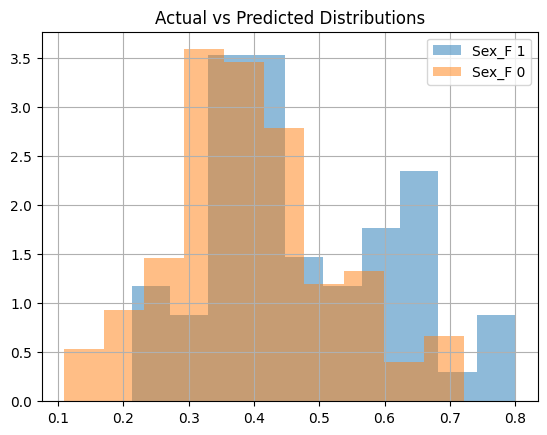

In [41]:
test_df_sex = pd.DataFrame(list(zip(y_sex_f,(y_preds[:,1]))), columns=['actual','predicted'])

# Plot the distros and look at spread
test_df_sex.loc[test_df_sex['actual']==1]['predicted'].hist(alpha=.5, label='Sex_F 1', density=True)
test_df_sex.loc[test_df_sex['actual']==0]['predicted'].hist(alpha=.5, label='Sex_F 0', density=True)
plt.title('Actual vs Predicted Distributions')
plt.legend();


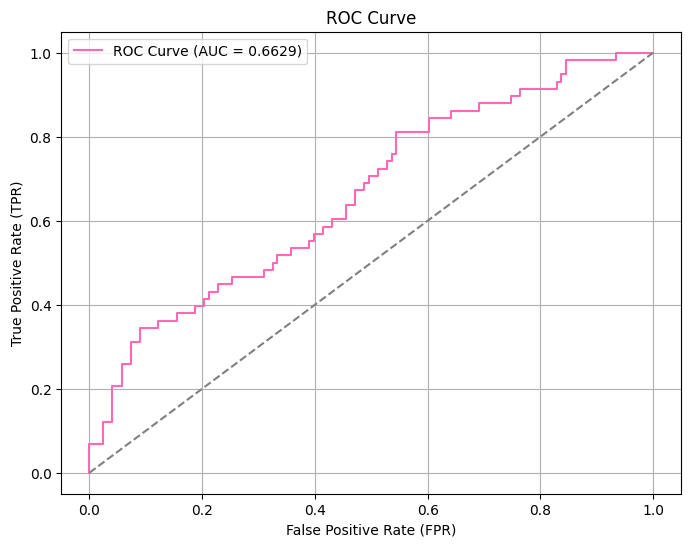

In [42]:

precision_vals, recall_vals, thresholds = precision_recall_curve(y_sex_f, y_preds[:,1])
# Compute ROC curve and AUC score
fpr, tpr, roc_thresholds = roc_curve(y_sex_f, y_preds[:, 1])  # Assuming y_pred contains probabilities for class 1
auc_score = roc_auc_score(y_sex_f, y_preds[:, 1])

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='hotpink', label=f'ROC Curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--') 
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()



In [75]:
# Compute optimal threshold
j_scores = tpr - fpr 
optimal_idx = j_scores.argmax()  
optimal_threshold = .4 #roc_thresholds[optimal_idx]

#Redoing with optimal threshold.
y_pred_thresh = (y_pred_proba[:, 1] >= optimal_threshold).astype(int)  # Taking column 1 (positive class probability)
print('Original accuracies:')
print(f"Accuracy for sex (classification): {accuracy_score(y1_test, y_pred):.4f}")
print(f"F1 for sex (classification): {f1_score(y1_test, y_pred):.4f}")
print('Threshold optimized accuracies:')
print(f"Accuracy for sex (classification): {accuracy_score(y1_test, y_pred_thresh):.4f}")
print(f"F1 for sex (classification): {f1_score(y1_test, y_pred_thresh):.4f}")
print("")
conf_matrix = confusion_matrix(y1_test, y_pred_thresh)
print("Confusion Matrix:")
print(conf_matrix)

Original accuracies:


ValueError: Found input variables with inconsistent numbers of samples: [203, 269]

In [ ]:
test_df_sex = pd.DataFrame(list(zip(y1_test,(y_pred_proba[:,1]))), columns=['actual','predicted'])

# Plot the distros and look at spread
test_df_sex.loc[test_df_sex['actual']==1]['predicted'].hist(alpha=.5, label='Sex_F 1', density=True)
test_df_sex.loc[test_df_sex['actual']==0]['predicted'].hist(alpha=.5, label='Sex_F 0', density=True)
plt.title('Actual vs Predicted Distributions')
plt.legend();